In [1]:
# 1. My current implementation of the Differentiable Darmois construction does not have triangular Jacobian
# 2. That is because the MAF implementation employs flow.Reverse() layers, which change the order of the variables across successive layers
# 3. If I remove those, the network does not appear to learn any nonlinear transformation for the 1st component; it only applies an (almost?) linear transformation to the first variable
# 4. (Additionally, there appears to be some problem with the Jacobian... Somehow I don't manage to figure out  
#     how to evaluate it -- neither with nor without vmap -- on the Flow and get the correct dimensionality.)

# QUESTIONS: 1. Can I find a better autoregressive flow, more expressive than MAF? -> A: Try Neural Spline Flows.
#            2. Can I evaluate the goddamn Jacobian properly with it?

# Alternative path
# 5. Focuse on closed form implementation for now
# 6. Try again with Neural Spline Flows

In [2]:
# For the closed form implementation you might need the error function and/or its inverse, possibly in a differentiable form

In [3]:
from jax import numpy as np

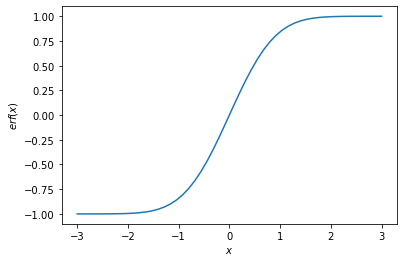

In [4]:
from scipy import special
import matplotlib.pyplot as plt
x = np.linspace(-3, 3)

plt.plot(x, special.erf(x))
plt.xlabel('$x$')
plt.ylabel('$erf(x)$')
plt.show()

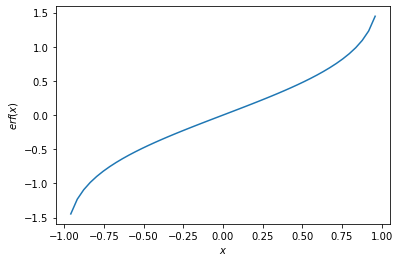

In [5]:
from jax.scipy import special
y = np.linspace(-1.0, 1.0)

plt.plot(y, special.erfinv(y))
plt.xlabel('$x$')
plt.ylabel('$erf(x)$')
plt.show()

### 1. Generate data from a uniform distribution

In [24]:
# N:=Number of samples
N = 60000
# D:=Number of dimensions
D = 2

In [25]:
from jax import random
key = random.PRNGKey(0)

S = random.uniform(key, shape=(D, N), minval=0.0, maxval=1.0)

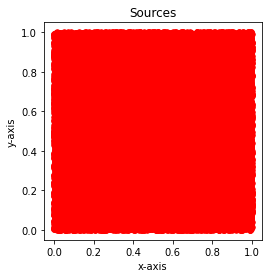

In [26]:
# Plot sources
plt.scatter(S[0], S[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Sources')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 2. Mixing (CDF + linear)

In [27]:
mean=np.zeros(D*2)
mean
cov=np.eye(D*2)
cov

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [28]:
A = random.multivariate_normal(key, mean=np.zeros(D*2), cov=np.eye(2*D)).reshape(2,2)

In [29]:
A.shape

(2, 2)

In [30]:
A_inv = np.linalg.inv(A)

In [31]:
# Turn them into normal R.V.
S_normal = special.erfinv(S*2.0-1.0)

# Check that they **are** normal!
Norm = random.multivariate_normal(key, mean=np.zeros(D), cov=np.eye(D), shape=[N]).T

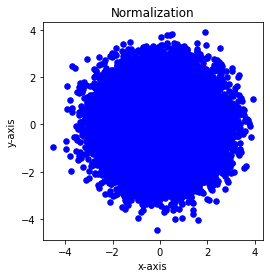

In [32]:
# Plot observations
plt.scatter(S_normal[0], S_normal[1], color='r', s=30)
plt.scatter(Norm[0], Norm[1], color='blue', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Normalization')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [33]:
Norm.shape

(2, 60000)

In [34]:
# Apply a linear mixing
X = A @ S_normal # * 2
# X = A @ Norm

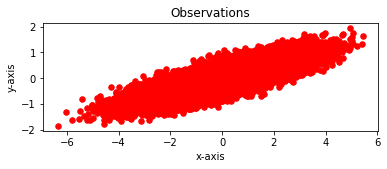

In [35]:
# Plot observations
plt.scatter(X[0], X[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 3. Build Darmois

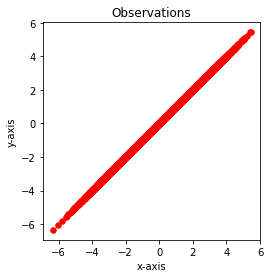

In [36]:
plt.scatter(X[0], A[0, 0]*S_normal[0]+A[0, 1]*S_normal[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

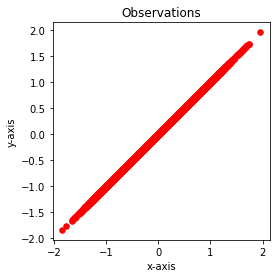

In [37]:
plt.scatter(X[1], A[1, 0]*S_normal[0]+A[1, 1]*S_normal[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [38]:
def darmois_linear_gaussian(A):
    sigma_0 = np.sqrt(A[0,0]**2 + A[0,1]**2) 
    sigma_1 = np.sqrt(A[1,0]**2 + A[1,1]**2) 
    rho_01 = (A[0,0]*A[1,0] + A[0,1]*A[1,1])/(sigma_0*sigma_1)
    c_1_given_0 = rho_01*sigma_1/sigma_0
    
    def darmois(x):
        y_0 = 0.5*(1 + special.erf(x[0]/(sigma_0*np.sqrt(2))))
        y_1 = 0.5*(1 + special.erf( (x[1] - c_1_given_0* x[0]) /np.sqrt( 2 * ( 1 - rho_01**2) * sigma_1**2 )))
        return np.vstack([y_0, y_1])

    return darmois

In [39]:
darmois = darmois_linear_gaussian(A)

In [40]:
Y = darmois(X)

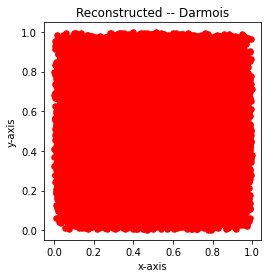

In [41]:
# Plot reconstructed -- Darmois
plt.scatter(Y[0], Y[1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Reconstructed -- Darmois')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# To do:
- Add colormap to visualize distorsion due to Darmois
- Invert the function!
- Compute its Jacobian/the various metrics